EDA를 추가적으로 진행하겠습니다. feature를 잘 만들어주는 것이 고성능을 내는 방법일 것 같습니다.

전처리도 많이 필요할 것 같습니다. 샘플링을 고려해보아야겠습니다.

# IMPORT & LOAD DATA

In [1]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')

import os, sys
import time
import datetime as dt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

In [2]:
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------

In [3]:
TRAIN_P_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv'
TRAIN_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv'
TRAIN_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv'
TEST_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv'
TEST_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/sample_submission.csv'

In [4]:
%%time
train_p = ld.load_dtypes(TRAIN_P_PATH)
train_q = ld.load_dtypes(TRAIN_Q_PATH)
train_e = ld.load_dtypes(TRAIN_E_PATH)
test_q = ld.load_dtypes(TEST_Q_PATH)
test_e = ld.load_dtypes(TEST_E_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv
Wall time: 1min 17s


In [5]:
train_p.shape, train_q.shape, train_e.shape, test_q.shape, test_e.shape, submission.shape

((5429, 2),
 (828624, 16),
 (16554663, 6),
 (747972, 16),
 (16532648, 6),
 (14999, 2))

In [6]:
def preprocessing_problem(df, object_='binary'):
    """
    definition:
    train_problem 테이블을 받아서 target 값으로 변환
    1. {0, 1}의 binary로 변환
    2. {0 ~ n}의 multiclass로 변환
    """
    
    # 10001부터 24999까지의 index를 만들어줍니다.
    user_id_idx = np.array(range(10000, 25000, 1))
    
    # train_new_p라는 새로운 df를 만들고 index는 위에서 만든 user_id_idx 로 지정해줍니다.
    new_p = pd.DataFrame(index = user_id_idx)
    new_p['target'] = 0
    
    if object_ == 'binary':
        new_p.iloc[df.user_id.unique()-10000] = 1       
        
    elif object_ == 'multi':
        # multi는 count()로 집계를 해줍니다.
        new_p['target'] = df.groupby('user_id')['time'].count()
        new_p = new_p.fillna(0)
        
    return new_p

In [7]:
train_b_p = preprocessing_problem(train_p, 'binary')

In [8]:
def preprocessing_quality(df):
    """
    definition:
    EDA를 통해 알아낸 정보로 train_q, test_q를 정리해서 내뿜어줍니다.
    1. qaulity_3, quality_4 를 drop 합니다.(단일 value)
    2. qaulity_k 변수들을 정수로 encoding 합니다.
    """
    # 먼저 3, 4번을 drop 합니다.
    df.drop(['quality_3', 'quality_4'], axis=1, inplace=True)
    
    # qual 변수만 할당해주고, 정수로 형변환 해줍니다.
    columns = train_q.columns[train_q.columns.str.contains('quality')]
    # for문을 통해 각 column을 반복 작업해줍니다.
    for col in columns:
        try:
            if df[col].dtype == 'float32': # 기존에 float은 패스
                df[col] = df[col].fillna(-2)
            elif df[col].dtype == 'int8' or df[col].dtype == 'int16': # 기존에 int도 패스
                df[col] = df[col].fillna(-2)
                #print(col)
            else:
                df[col] = df[col].astype('object')
                # nan값이 있으면 float으로 갈 수 없으니 '-2' 으로 채워줍니다.
                df[col] = df[col].fillna('-2')
                df[col] = df[col].apply(lambda x: x.replace(',' , ''))
                df[col] = df[col].astype(np.float32)
        except:
            pass
        
    # fwver 에서 null 값이 꽤 있습니다. missing으로 채우겠습니다.
    df.fwver = df.fwver.astype('object')
    df.fwver = df.fwver.fillna('missing')
    df.fwver = df.fwver.astype('category')
        
    return df

In [9]:
pre_train_q = preprocessing_quality(train_q)
pre_test_q = preprocessing_quality(test_q)

In [137]:
def preprocessing_fwver(df):
    """
    definition:
    별건 아니고, e-set에 fwver 변수에서 '10' 이라는 값이 있는데, 이게 errtype이랑 겹쳐요.
    그래서 10을 -> 10.00.0000 으로 바꿔줄 겁니다.
    """
    df.fwver = df.fwver.replace('10', '10.10.1000')
        
    return df

In [138]:
train_e = preprocessing_fwver(train_e)
test_e = preprocessing_fwver(test_e)

In [10]:
train_p

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000
...,...,...
5424,20167,20201125120000
5425,16270,20201110120000
5426,19114,20201106230000
5427,21505,20201104110000


In [11]:
test_e

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1
...,...,...,...,...,...,...
16532643,44998,20201130210050,model_1,04.16.3553,40,0
16532644,44998,20201130211831,model_1,04.16.3553,31,1
16532645,44998,20201130211832,model_1,04.16.3553,15,1
16532646,44998,20201130212259,model_1,04.16.3553,16,1


In [12]:
test_q

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201128195000,30000,04.33.1261,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0,2.0,0,0
1,20201128195000,30000,04.33.1261,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0,2.0,0,0
2,20201128195000,30000,04.33.1261,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0,2.0,0,0
3,20201128195000,30000,04.33.1261,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0,2.0,0,0
4,20201128195000,30000,04.33.1261,0.0,0.0,0.0,0.0,0,5.0,0.0,0.0,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747967,20201125180000,44997,04.22.1750,0.0,0.0,0.0,2.0,0,0.0,0.0,0.0,3.0,0,0
747968,20201125180000,44997,04.22.1750,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,3.0,0,0
747969,20201125180000,44997,04.22.1750,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,3.0,0,0
747970,20201125180000,44997,04.22.1750,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,3.0,0,0


# Feature Creation

### column: fwver

In [13]:
fwver_1 = pre_train_q.fwver.unique().to_list()
fwver_2 = pre_test_q.fwver.unique().to_list()
fwver_3 = train_e.fwver.unique().to_list()
fwver_4 = test_e.fwver.unique().to_list()

In [14]:
fwver_all = set(fwver_1 + fwver_2 + fwver_3 + fwver_4)

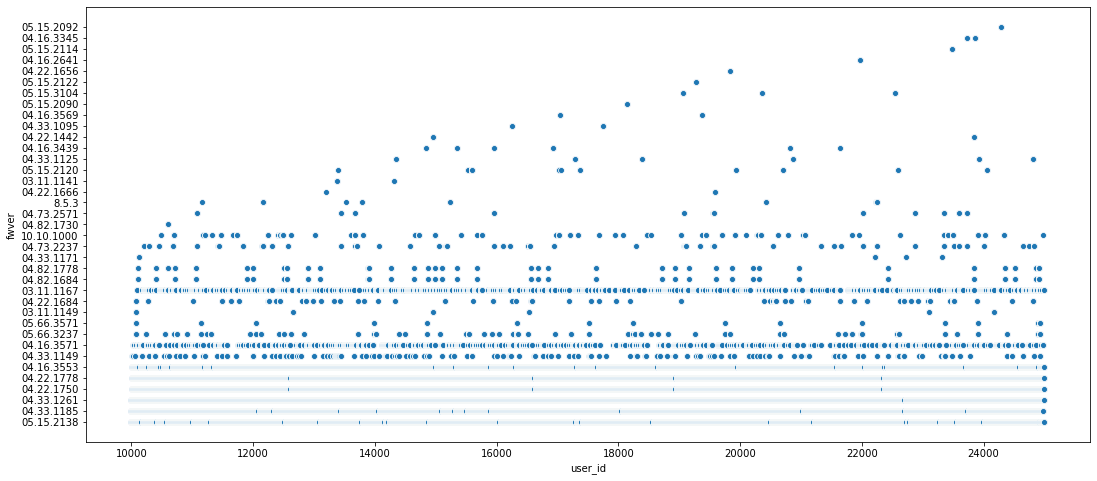

In [160]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=train_e, x='user_id', y='fwver')
plt.show()

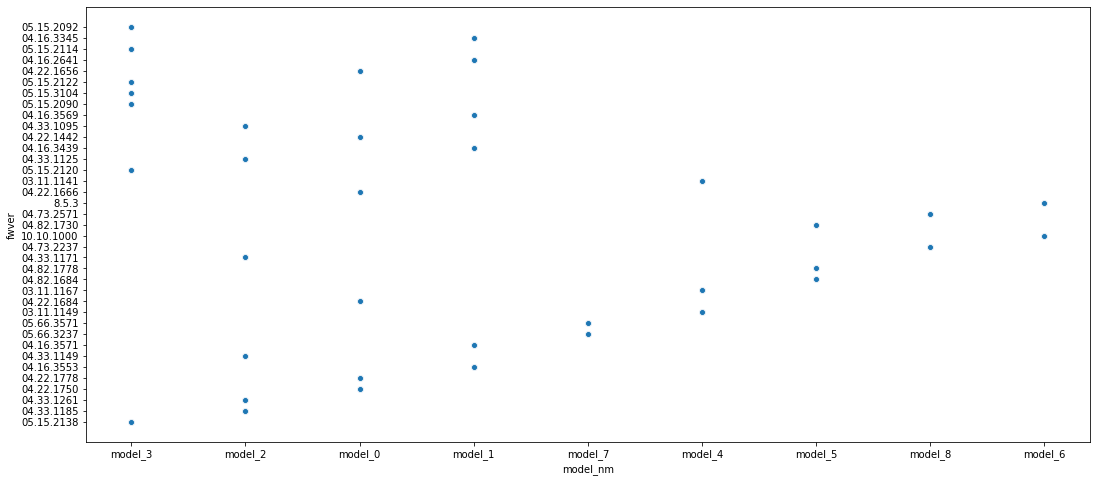

In [144]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=train_e, x='model_nm', y='fwver')
plt.show()

model이 모든 fwver값을 가지지는 않습니다. 적게는 2개에서 많게는 7개 정도의 값을 가집니다.

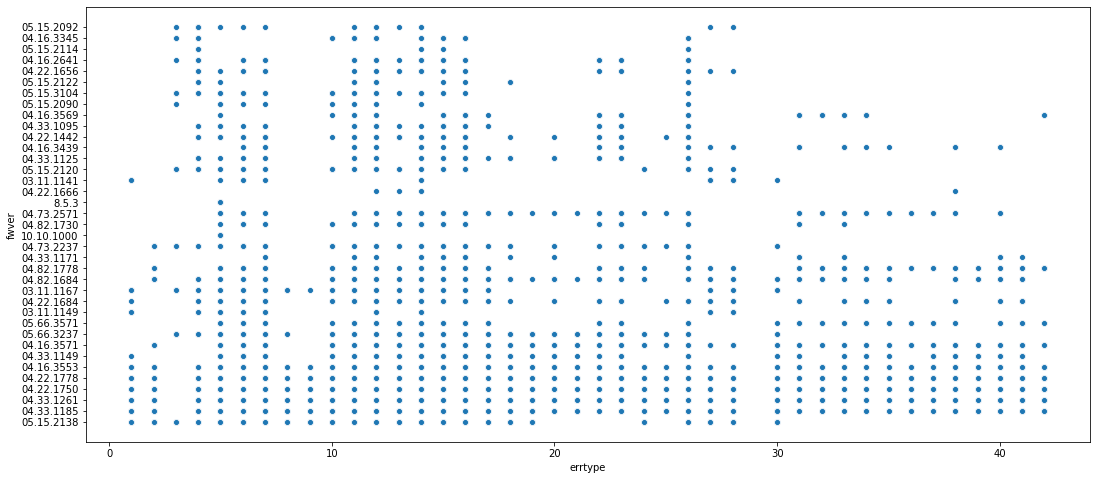

In [147]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=train_e, x='errtype', y='fwver')
plt.show()

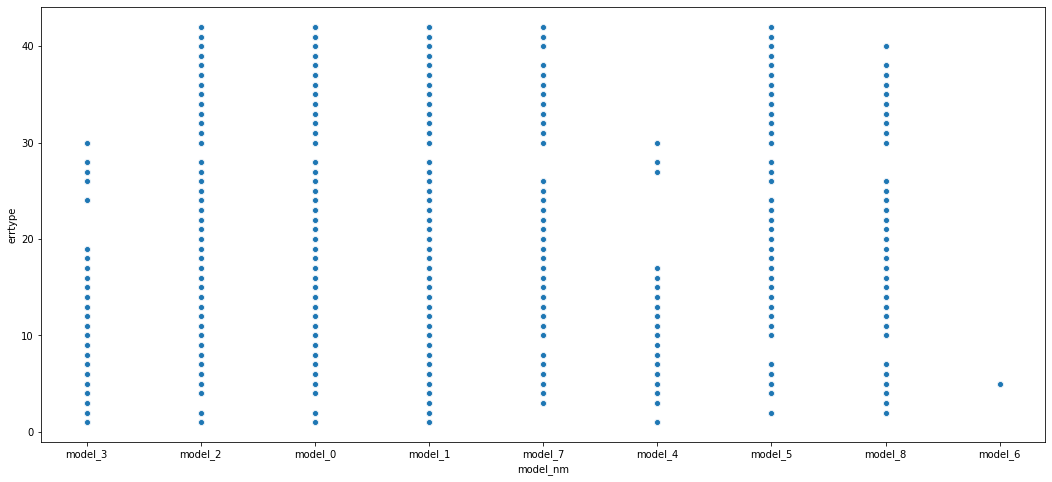

In [146]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=train_e, x='model_nm', y='errtype')
plt.show()

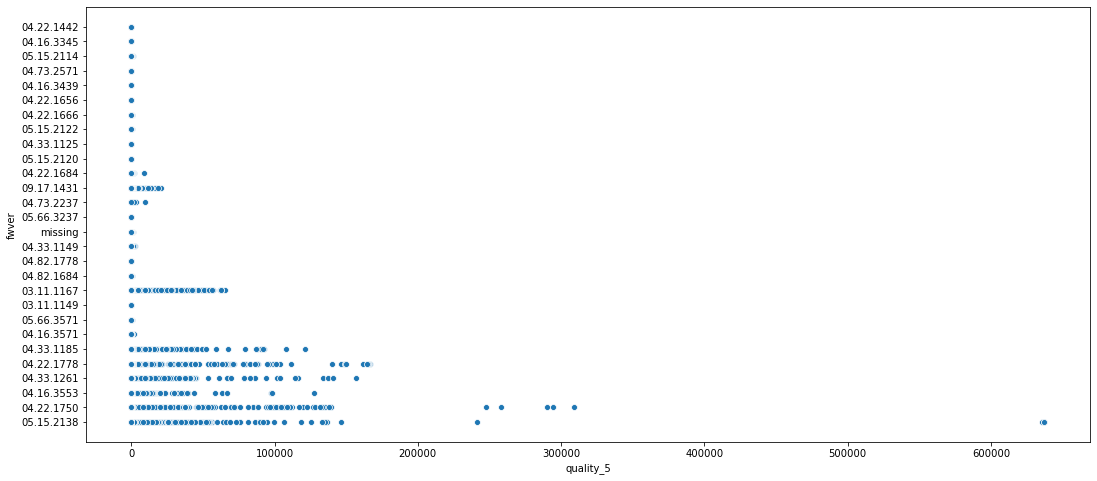

In [159]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=train_q, y='fwver', x='quality_5')
plt.show()

q에서도 특정 fwver에서만 quality가 커지는 경향이 있습니다. fwver이 가지는 힘이 꽤 커 보입니다.

In [161]:
train_fu_e = train_e.groupby(['user_id', 'fwver'])['errtype'].count().unstack()
test_fu_e = test_e.groupby(['user_id', 'fwver'])['errtype'].count().unstack()

quality 변수 테스트 다 하고, 최고 좋은 것에 더해봅시다.

### column: quality

quality columns를 어떻게 집어넣어야 할까에 대한 고민입니다. 일단 user 기반으로 해야하기 때문에 agg를 해줘야 하는 것은 맞습니다. 워낙 value가 천차만별이고 너무 많기 때문에 따로 column으로 떼어줄 수는 없습니다. 그렇다면 agg인데, std, mean, sum, max등의 방식을 자유롭게 써봐야겠습니다.

In [272]:
pre_train_q_std = pre_train_q.groupby('user_id').std()
pre_test_q_std = pre_test_q.groupby('user_id').std()

In [273]:
pre_train_q_mean = pre_train_q.groupby('user_id').mean()
pre_test_q_mean = pre_test_q.groupby('user_id').mean()

In [300]:
pre_train_q_sum = pre_train_q.groupby('user_id').sum()
pre_test_q_sum = pre_test_q.groupby('user_id').sum()

In [303]:
pre_train_q_max = pre_train_q.groupby('user_id').max()
pre_test_q_max = pre_test_q.groupby('user_id').max()

# Train & Predict

In [229]:
errt_train_e = train_e.groupby(['user_id', 'errtype'])['errtype'].count().unstack()
errt_test_e = test_e.groupby(['user_id', 'errtype'])['errtype'].count().unstack()

In [230]:
errt_train_e.fillna(0, inplace=True)
errt_test_e.fillna(0, inplace=True)

In [233]:
# 하나 사라진 유저를 채워주는 코드입니다.
#errt_train_e = errt_train_e.reindex(pd.RangeIndex(errt_train_e.index.max() + 1)).ffill(0)[30000:]
errt_test_e = errt_test_e.reindex(pd.RangeIndex(errt_test_e.index.max() + 1)).ffill(0)[30000:]

In [285]:
x_train_std = pd.concat([errt_train_e, pre_train_q_std], axis=1).fillna(0)
x_test_std = pd.concat([errt_test_e, pre_test_q_std], axis=1).fillna(0)
x_train_mean = pd.concat([errt_train_e, pre_train_q_mean], axis=1).fillna(0)
x_test_mean = pd.concat([errt_test_e, pre_test_q_mean], axis=1).fillna(0)

In [314]:
x_train_sum = pd.concat([errt_train_e, pre_train_q_sum], axis=1).fillna(0)
x_test_sum = pd.concat([errt_test_e, pre_test_q_sum], axis=1).fillna(0)
x_train_max = pd.concat([errt_train_e, pre_train_q_max], axis=1).fillna(0)
x_test_max = pd.concat([errt_test_e, pre_test_q_max], axis=1).fillna(0)

In [235]:
def s_fold_train_pred(train_x, train_y):
    import lightgbm as lgb

    # Train
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': 42
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    s_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    

    for train_idx, val_idx in s_fold.split(train_x, train_y):

        # split train, validation set
        X = train_x.iloc[train_idx]
        y = train_y.iloc[train_idx]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y.iloc[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 20, 
                            early_stopping_rounds = 3
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    return models, auc_scores, recalls, precisions

In [319]:
models, auc_scores, _, _ = s_fold_train_pred(x_train_std, train_b_p)
print(np.mean(auc_scores))

pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_std)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7044
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
[20]	valid_0's auc: 0.80632	valid_0's pr_auc: 0.720215
Early stopping, best iteration is:
[23]	valid_0's auc: 0.807282	valid_0's pr_auc: 0.724104
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7048
[LightGBM] [Info] Number of dat

In [290]:
submission.problem = pred_ensemble
submission
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210111_2_quality-std.csv', index=False)

,user_id,problem
0,30000,0.613095
1,30001,0.327420
2,30002,0.303258
3,30003,0.524009
4,30004,0.497476
...,...,...
14994,44994,0.325095
14995,44995,0.347757
14996,44996,0.417397
14997,44997,0.636102


In [317]:
models, auc_scores, _, _ = s_fold_train_pred(x_train_mean, train_b_p)
print(np.mean(auc_scores))

pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_mean)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7005
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
[20]	valid_0's auc: 0.804215	valid_0's pr_auc: 0.716978
Early stopping, best iteration is:
[29]	valid_0's auc: 0.806284	valid_0's pr_auc: 0.723713
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7016
[LightGBM] [Info] Number of da

In [ ]:
submission.problem = pred_ensemble
submission
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210111_3_quality-mean.csv', index=False)

In [321]:
models, auc_scores, _, _ = s_fold_train_pred(x_train_sum, train_b_p)
print(np.mean(auc_scores))

pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_sum)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6428
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
[20]	valid_0's auc: 0.80658	valid_0's pr_auc: 0.720788
Early stopping, best iteration is:
[31]	valid_0's auc: 0.809728	valid_0's pr_auc: 0.729927
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6449
[LightGBM] [Info] Number of dat

In [323]:
submission.problem = pred_ensemble
submission
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210111_4_quality-sum.csv', index=False)

,user_id,problem
0,30000,0.619873
1,30001,0.262693
2,30002,0.330129
3,30003,0.553642
4,30004,0.480939
...,...,...
14994,44994,0.316400
14995,44995,0.329002
14996,44996,0.404688
14997,44997,0.642921


In [324]:
models, auc_scores, _, _ = s_fold_train_pred(x_train_max, train_b_p)
print(np.mean(auc_scores))

pred_y_list = []
for model in models:
    pred_y = model.predict(x_test_max)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5775
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 3 rounds
[20]	valid_0's auc: 0.804365	valid_0's pr_auc: 0.717741
Early stopping, best iteration is:
[21]	valid_0's auc: 0.80515	valid_0's pr_auc: 0.719253
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5785
[LightGBM] [Info] Number of dat

In [326]:
submission.problem = pred_ensemble
submission
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210111_5_quality-max.csv', index=False)

,user_id,problem
0,30000,0.550264
1,30001,0.296201
2,30002,0.303164
3,30003,0.499214
4,30004,0.425839
...,...,...
14994,44994,0.319532
14995,44995,0.338807
14996,44996,0.388210
14997,44997,0.587895


# axis: Time

time x user 축으로 df를 만들고, 그에 맞춰 agg를 시키는 것입니다.

예측도 time x user 축으로 한 다음, 해당 시간에 time x user에 error가 날 확률을 구해서, user 단위로 뭉쳐주면 되지 않을까요?

어렵습니다. 매우 어려워요. 다만 데이터가 1.5만개에서 1100만개로 1000배가 늘어납니다.

문제는 imbalance죠. 1이 약 5.5천개인데, 1000만개 중에 5.5천개면 0.01%도 안됩니다. over sampling이 엄청 필요합니다.

### step_1: to_datetime()

In [15]:
def make_datetime(df, column_name):
    # df 와 column_name을 받아서 datetime 컬럼을 반환해주는 함수
    
    df['year'] = df[column_name].apply(lambda x: str(x)[:4])
    df['month'] = df[column_name].apply(lambda x: str(x)[4:6])
    df['day'] = df[column_name].apply(lambda x: str(x)[6:8])
    df['hour'] = df[column_name].apply(lambda x: str(x)[8:10])
    df['minute'] = '00' # minute을 넣어주지 않으면 datetime이 완성이 안되니, 00으로 넣어줍니다.
    
    df[column_name] = pd.to_datetime(df.year + df.month + df.day + df.hour + df.minute)
    
    return df

In [16]:
train_t_p = make_datetime(train_p, 'time')
# q는 전처리한 친구로 넣어줍니다.
train_t_q = make_datetime(pre_train_q, 'time')
test_t_q = make_datetime(pre_test_q, 'time')

train_t_e = make_datetime(train_e, 'time')
test_t_e = make_datetime(test_e, 'time')

### step_2: agg by time, user

In [63]:
train_tu_q = train_t_q.groupby(['time', 'user_id']).std().reset_index()
test_tu_q = test_t_q.groupby(['time', 'user_id']).std().reset_index()

In [64]:
train_tu_e = train_t_e.groupby(['time', 'user_id', 'errtype'])['errtype'].count().unstack().reset_index()
test_tu_e = test_t_e.groupby(['time', 'user_id', 'errtype'])['errtype'].count().unstack().reset_index()

In [65]:
train_t_p

,user_id,time,year,month,day,hour,minute
0,19224,2020-11-02 20:00:00,2020,11,02,20,00
1,23664,2020-11-16 14:00:00,2020,11,16,14,00
2,15166,2020-11-14 13:00:00,2020,11,14,13,00
3,12590,2020-11-08 21:00:00,2020,11,08,21,00
4,15932,2020-11-03 21:00:00,2020,11,03,21,00
...,...,...,...,...,...,...,...
5424,20167,2020-11-25 12:00:00,2020,11,25,12,00
5425,16270,2020-11-10 12:00:00,2020,11,10,12,00
5426,19114,2020-11-06 23:00:00,2020,11,06,23,00
5427,21505,2020-11-04 11:00:00,2020,11,04,11,00


In [59]:
# test_e 의 periods
e_periods = pd.date_range(start='2020-10-31 23:00:00',
                            end='2020-12-14 12:00:00',
                            freq='H')

In [78]:
# p, q 의 periods
p_periods = pd.date_range(start='2020-11-01 00:00:00',
                            end='2020-11-30 23:00:00',
                            freq='H')

In [99]:
days = list(sorted(train_t_p.day.unique()))
hours = list(sorted(train_t_p.hour.unique()))
user_x = list(range(10000, 25000, 1))
user_y = list(range(30000, 44999, 1))

In [100]:
columns = ['day', 'hour', 'user_x']

temp = []

for day in days:
    for hour in hours:
        for user in user_x:
            temp.append([day, hour, user])

temp = pd.DataFrame(data=temp, columns=columns)

In [102]:
temp['year-month'] = '2020-11'
temp

,day,hour,user_x,year-month
0,01,00,10000,2020-11
1,01,00,10001,2020-11
2,01,00,10002,2020-11
3,01,00,10003,2020-11
4,01,00,10004,2020-11
...,...,...,...,...
10799995,30,23,24995,2020-11
10799996,30,23,24996,2020-11
10799997,30,23,24997,2020-11
10799998,30,23,24998,2020-11
